In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq
import pickle as pkl
import pandas as pd
import umap.umap_ as umap

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_665099/1194137215.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))


Ensemble AUC: 0.995, Ensemble Accuracy: 0.936


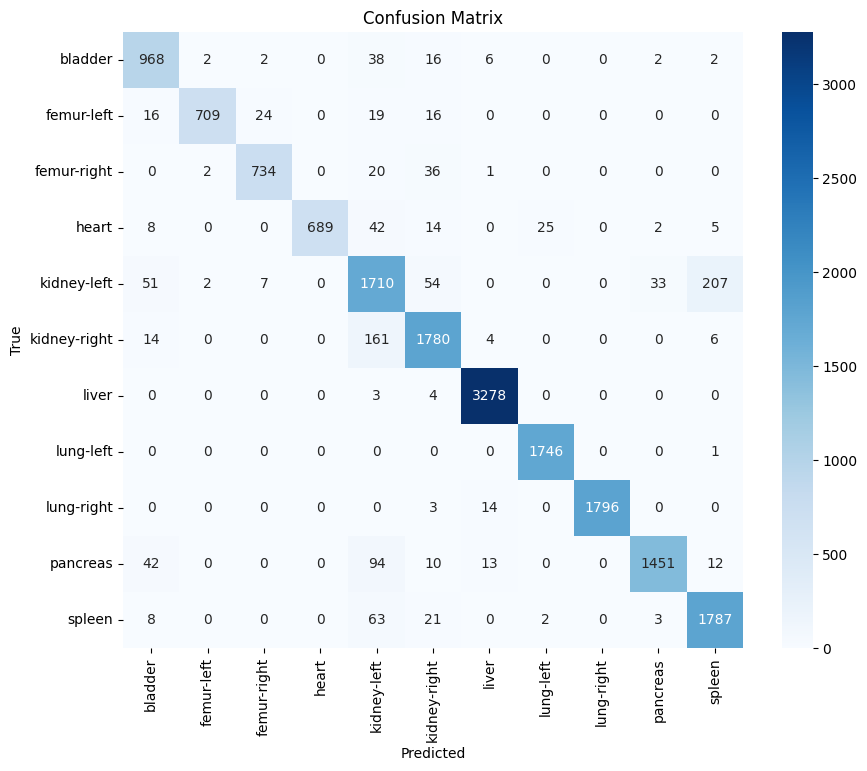

In [5]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Evaluate the ensemble model
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_scores)
print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

# Generate the confusion matrix

cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
from sklearn.metrics import balanced_accuracy_score, recall_score, confusion_matrix

# Compute balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))
print(f'Balanced Accuracy: {balanced_acc:.3f}')

# Compute sensitivity (recall)
sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
print(f'Sensitivity: {sensitivity:.3f}')

# Compute specificity
cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
# Number of classes
num_classes = cm.shape[0]

# Compute specificity for each class
specificities = []
for i in range(num_classes):
    FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives: sum of column i, excluding diagonal
    TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives: everything else
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0  # Avoid division by zero
    specificities.append(specificity)

# Compute macro specificity
macro_specificity = np.mean(specificities)

# Print result
print(f"Macro-Averaged Specificity: {macro_specificity:.4f}")

Balanced Accuracy: 0.928
Sensitivity: 0.928
Macro-Averaged Specificity: 0.9935


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Set the random seed for reproducibility
torch.manual_seed(42)

# Calculate the sizes for training and calibration datasets
train_size = int(0.8 * len(combined_train_dataset))
calibration_size = len(combined_train_dataset) - train_size

# Split the combined_train_dataset into training and calibration datasets
train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

# Create DataLoaders for the new training and calibration datasets
calibration_loader = DataLoader(dataset=calibration_dataset, batch_size=128, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calibration_dataset)}')

Training dataset size: 32841
Calibration dataset size: 8211


In [8]:
# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=128, shuffle=True, drop_last=True)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

/tmp/ipykernel_665099/3139380480.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
/tmp/ipykernel_665099/3139380480.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))


Calibration AUC: 1.000, Calibration Accuracy: 0.998, Calibration Balanced Accuracy: 0.997


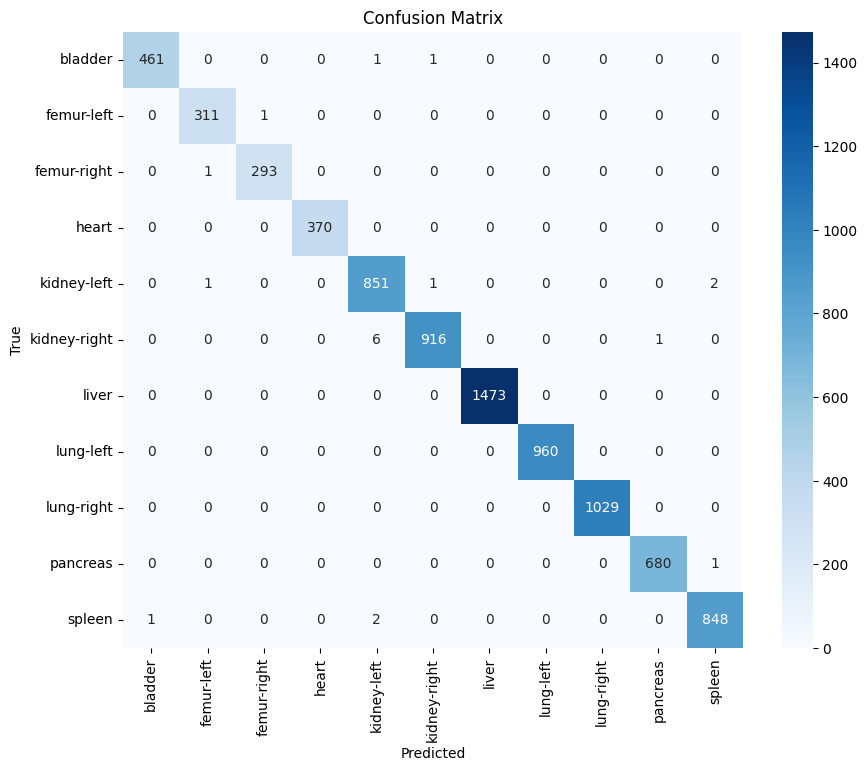

In [9]:
# Perform inference on the test set
y_true_calibration = []
y_scores_calibration = []
indiv_scores_calibration = [[], [], [], [], []]

with torch.no_grad():
    for data, target in calibration_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores_calibration, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true_calibration.extend(target.cpu().numpy().flatten())
        y_scores_calibration.extend(avg_output.cpu().numpy())

y_true_calibration = np.array(y_true_calibration)
y_scores_calibration = np.array(y_scores_calibration)
y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))
# Compute AUC, Accuracy, and Balanced Accuracy for the calibration dataset

# Compute AUC
auc_calibration = roc_auc_score(y_true_calibration, y_prob_calibration, multi_class='ovr')

# Compute Accuracy
acc_calibration = accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

# Compute Balanced Accuracy
bacc_calibration = balanced_accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

print(f'Calibration AUC: {auc_calibration:.3f}, Calibration Accuracy: {acc_calibration:.3f}, Calibration Balanced Accuracy: {bacc_calibration:.3f}')

# Generate the confusion matrix
cm = confusion_matrix(y_true_calibration, y_scores_calibration.argmax(axis=1))
# 
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))

/tmp/ipykernel_665099/2939530776.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [11]:
correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

In [12]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [13]:
from torchsummary import summary

# Assuming 'model' is an instance of your ResNet18 class
model = ResNet18(num_classes=num_classes).to(device)

# Print the summary of the model
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
models = [model.to(device) for model in models]
latent_spaces = []
shap_values_folds = []
success_folds = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold].model).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        classifierheadwrapper=classifier_head,
        shap_explainer='DeepExplainer',
        max_background_samples=50
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)
    success_folds.append(success.squeeze() if success.ndim > 1 else success)

In [14]:
# Load the SHAP results from the pickle file
with open('shap_results.pkl', 'rb') as file:
    shap_results = pkl.load(file)

In [15]:
mean_shap_importances = []
for fold, shap_values in enumerate(shap_results['shap_values_folds']):
    mean_shap_fold = []
    print(f"Fold {fold}: SHAP Feature Importances")

    # Ensure shap_values is a 3D array
    num_samples, num_features, num_classes = shap_values.shape

    for class_idx in range(num_classes):
        print(f"Class {class_idx}: SHAP Feature Importances")

        # Extract SHAP values for the current class
        class_shap_values = shap_values[:, :, class_idx]

        # Create a DataFrame for SHAP values of the current class
        shap_df = pd.DataFrame(
            class_shap_values,
            columns=[f"Feature_{i}" for i in range(num_features)]
        )
        
        # Compute mean absolute SHAP values
        mean_abs_shap = shap_df.abs().mean(axis=0)
        
        # Select top 50 features
        top_50_features = mean_abs_shap.nlargest(50).index
        
        # Keep only the top 50 features
        shap_df_top_50 = shap_df[top_50_features]
        
        shap_importance = uq.display_shap_values(shap_df_top_50)
        print(shap_importance)
        mean_shap_fold.append((fold, class_idx, shap_importance))
    mean_shap_importances.append(mean_shap_fold)

Fold 0: SHAP Feature Importances
Class 0: SHAP Feature Importances
Feature_95     0.102454
Feature_387    0.089751
Feature_105    0.085444
Feature_269    0.084808
Feature_370    0.083465
Feature_385    0.082856
Feature_209    0.081113
Feature_394    0.078637
Feature_383    0.073735
Feature_56     0.073273
Feature_292    0.072820
Feature_481    0.071914
Feature_118    0.071492
Feature_198    0.069165
Feature_39     0.069058
Feature_264    0.066209
Feature_358    0.065782
Feature_362    0.065022
Feature_57     0.064231
Feature_344    0.064045
Feature_86     0.063671
Feature_406    0.063198
Feature_499    0.062799
Feature_487    0.061180
Feature_506    0.060597
Feature_443    0.060588
Feature_50     0.057344
Feature_217    0.055792
Feature_232    0.055420
Feature_304    0.054935
Feature_322    0.054604
Feature_285    0.053616
Feature_13     0.053330
Feature_335    0.053224
Feature_53     0.052979
Feature_343    0.052858
Feature_371    0.052325
Feature_210    0.051939
Feature_113    0.0519

In [17]:
latent_spaces_df = []
for fold, latent_space in enumerate(shap_results['latent_spaces']):
    num_samples, num_features = latent_space.shape
    latent_space_df = pd.DataFrame(
        latent_space,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    latent_spaces_df.append(latent_space_df)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


plt.close('all')
successes_folds = []
knn_distances_folds = []

for fold in range(5):
    successes = []
    knn_distances = []
    indices = []
    
    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    
    latent_space_test, labels_test, success_test, preds_test = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    
    train_latent_space = pd.DataFrame(latent_space_training, columns=latent_spaces_df[fold].columns)
    test_latent_space = pd.DataFrame(latent_space_test, columns=latent_spaces_df[fold].columns)
    
    knn_distances_all = np.zeros(len(test_latent_space))
    successes_all = np.zeros(len(test_latent_space))
    
    for i in range(11):
        print('class' + str(i))
        train_latent_space_class = train_latent_space[mean_shap_importances[fold][i][2].keys()]
        
        mask_training = labels_training == i
        train_latent_space_filtered = train_latent_space_class[mask_training]
        
        print(f'Number of samples with true label {i}: {len(train_latent_space_filtered)}')
        
        test_latent_space_class = test_latent_space[mean_shap_importances[fold][i][2].keys()]
        
        mask_test = labels_test == i
        test_latent_space_filtered = test_latent_space_class[mask_test]
        
        print(f'Number of samples with true label {i}: {len(test_latent_space_filtered)}')
        
        success_test_filtered = success_test[mask_test.flatten()]
        indices_test_filtered = np.where(mask_test.flatten())[0]
        
        scaler = StandardScaler()
        train_latent_space_standardized = scaler.fit_transform(train_latent_space_filtered)
        
        pca = PCA(n_components=0.9)
        train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
        
        test_latent_space_standardized = scaler.transform(test_latent_space_filtered)
        test_latent_space_pca = pca.transform(test_latent_space_standardized)
        
        knn = NearestNeighbors(n_neighbors=5)
        knn.fit(train_latent_space_pca)
        distances, _ = knn.kneighbors(test_latent_space_pca)
        
        average_distances = distances.mean(axis=1)
        
        knn_distances_all[indices_test_filtered] = average_distances
        successes_all[indices_test_filtered] = success_test_filtered
    
    knn_distances_folds.append(knn_distances_all)
    successes_folds.append(successes_all)

        # # Initialize UMAP
        # reducer = umap.UMAP(n_components=2, random_state=42)

        # # Fit and transform the latent space
        # embedding = reducer.fit_transform(train_latent_space_filtered)
        # embedding_test = reducer.transform(test_latent_space_filtered)
        # # Plot the UMAP embedding
        # plt.figure(figsize=(10, 8))
        # plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral')

        # # Overlay the test data with success and failure colors
        # success_colors = ['green' if success else 'red' for success in success_test_filtered]
        # plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors, s=5, alpha=0.3)

        # plt.title('UMAP projection of the filtered latent space')
        # plt.xlabel('UMAP 1')
        # plt.ylabel('UMAP 2')
        # plt.show()

class0
Number of samples with true label 0: 1450
Number of samples with true label 0: 1036
class1
Number of samples with true label 1: 1047
Number of samples with true label 1: 784
class2
Number of samples with true label 2: 1027
Number of samples with true label 2: 793
class3
Number of samples with true label 3: 1194
Number of samples with true label 3: 785
class4
Number of samples with true label 4: 2940
Number of samples with true label 4: 2064
class5
Number of samples with true label 5: 2820
Number of samples with true label 5: 1965
class6
Number of samples with true label 6: 4572
Number of samples with true label 6: 3285
class7
Number of samples with true label 7: 3189
Number of samples with true label 7: 1747
class8
Number of samples with true label 8: 3124
Number of samples with true label 8: 1813
class9
Number of samples with true label 9: 2302
Number of samples with true label 9: 1622
class10
Number of samples with true label 10: 2575
Number of samples with true label 10: 1884

In [25]:
# Calculate the mean of the lists inside knn_distances_folds
mean_knn_distances = np.mean(knn_distances_folds, axis=0)

# Print the result
print(mean_knn_distances)

[2.06649063e+00 1.78512232e-01 8.59840897e-02 ... 8.73538212e+01
 4.43165700e+00 5.51972749e+00]


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:402: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


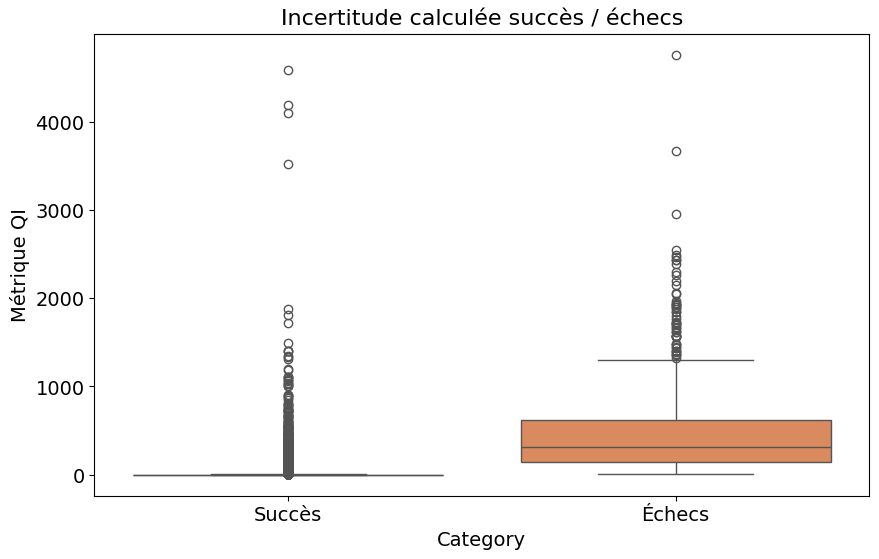

In [27]:
uq.UQ_method_plot([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions], 'Métrique QI', 'Incertitude calculée succès / échecs', swarmplot=False)

In [28]:
fpr_std_knn, tpr_std_knn, auc_std_knn = uq.roc_curve_UQ_method_computation([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions])

In [29]:
auc_std_knn

np.float64(0.9796472403073744)

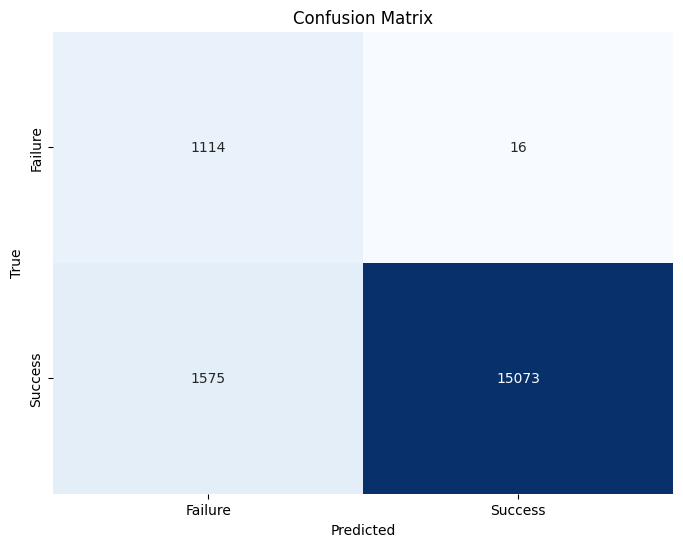

Optimal Threshold: 23.838416415669904
Balanced Accuracy: 0.946
Specificity: 0.986
Sensitivity: 0.905


In [30]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_balanced_acc = 0
    for threshold in thresholds:
        _, _, _, _, _, _, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_threshold = threshold
    return best_threshold

# Find the optimal threshold
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_knn_distances))])
optimal_threshold = find_optimal_threshold(mean_knn_distances, labels)

# Compute the confusion matrix using the optimal threshold
predictions = (mean_knn_distances <= optimal_threshold).astype(int)
cm = confusion_matrix(labels, predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the optimal threshold and balanced accuracy
_, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(mean_knn_distances, labels, optimal_threshold)
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")

In [32]:
knn_distances_all = []
for fold in range(5):
    successes = []
    knn_distances = []
    indices = []
    
    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    
    latent_space_test, labels_test, success_test, preds_test = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    
    train_latent_space = pd.DataFrame(latent_space_training, columns=latent_spaces_df[fold].columns)
    test_latent_space = pd.DataFrame(latent_space_test, columns=latent_spaces_df[fold].columns)
        
        
    scaler = StandardScaler()
    train_latent_space_standardized = scaler.fit_transform(train_latent_space)
    
    pca = PCA(n_components=0.9)
    train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
    
    test_latent_space_standardized = scaler.transform(test_latent_space)
    test_latent_space_pca = pca.transform(test_latent_space_standardized)
    
    knn = NearestNeighbors(n_neighbors=5)
    knn.fit(train_latent_space_pca)
    distances, _ = knn.kneighbors(test_latent_space_pca)
    
    average_distances = distances.mean(axis=1)
    
    knn_distances_all.append(average_distances)

In [37]:
# Calculate the mean of the lists inside knn_distances_folds
mean_knn_distances = np.mean(knn_distances_all, axis=0)

# Print the result
print(mean_knn_distances)

[2.00566203 1.26873018 0.13590587 ... 2.11054323 1.35395822 1.06453278]


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:402: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


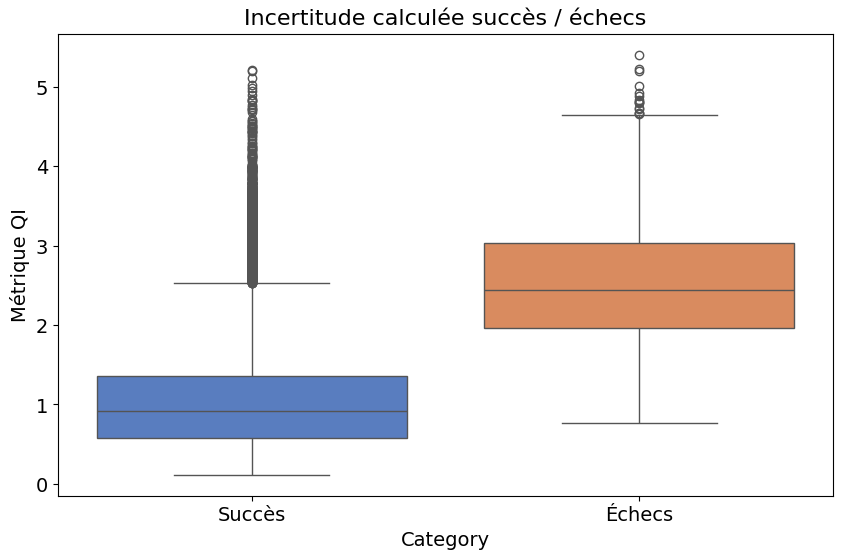

In [38]:
uq.UQ_method_plot([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions], 'Métrique QI', 'Incertitude calculée succès / échecs', swarmplot=False)

In [39]:
fpr_std_knn, tpr_std_knn, auc_std_knn = uq.roc_curve_UQ_method_computation([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions])

In [40]:
auc_std_knn

np.float64(0.9160406735189429)

In [ ]:
fpr_std_rt, tpr_std_rt, auc_std_rt = uq.roc_curve_UQ_method_computation([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions])

In [ ]:
mean_shap_importances = []
for fold, shap_values in enumerate(shap_results['shap_values_folds']):
    print(f"Fold {fold}: SHAP Feature Importances")

    # Ensure shap_values is a 2D array
    num_samples, num_features = shap_values.shape

    # Create a DataFrame for SHAP values
    shap_df = pd.DataFrame(
        shap_values,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    
    shap_importance = uq.display_shap_values(shap_df)
    print(shap_importance)
    mean_shap_importances.append(shap_importance)

In [ ]:
latent_spaces_df = []
for fold, latent_space in enumerate(shap_results['latent_spaces']):
    num_samples, num_features = latent_space.shape
    latent_space_df = pd.DataFrame(
        latent_space,
        columns=[f"Feature_{i}" for i in range(num_features)]
    )
    latent_spaces_df.append(latent_space_df)

In [ ]:
plt.close('all')
for fold, shap_importance in enumerate(mean_shap_importances):
    uq.plot_shap_importance(shap_importance, fold)


In [ ]:
# Plot for each fold
for fold, features in enumerate(shap_results['latent_spaces']):
    uq.plot_clustered_feature_heatmap(features, fold)

In [ ]:


plt.close('all')
reduced_latent_spaces = []
selected_features = []
distances_folds = []
preds_folds = []

for fold in range(0,5):
    final_latent_space, final_features = uq.feature_engineering_pipeline(
        mean_shap_df=mean_shap_importances[fold],
        latent_space=latent_spaces_df[fold],
        shap_threshold=0.04,
        corr_threshold=0.8)
    reduced_latent_spaces.append(final_latent_space)
    selected_features.append(final_features)
    
    uq.plot_shap_importance(mean_shap_importances[fold], fold, final_features)

    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    train_latent_space = pd.DataFrame(latent_space_training, columns=latent_spaces_df[fold].columns)
    
    latent_space_test, labels_test, success_test, preds_test = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    preds_folds.append(preds_test)
    test_latent_space = pd.DataFrame(latent_space_test, columns=latent_spaces_df[fold].columns)
    
    train_latent_space = train_latent_space[final_features]
    test_latent_space = test_latent_space[final_features]
    normalized_latent_space_train = (train_latent_space - train_latent_space.mean(axis=0)) / train_latent_space.std(axis=0)
    normalized_latent_space_test = (test_latent_space - test_latent_space.mean(axis=0)) / test_latent_space.std(axis=0)

    # Convert labels to a 1D array
    labels_train_fold = labels_training.flatten()
    labels_test_fold = labels_test.flatten()
    # Initialize UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=1000, random_state=42)

    # Fit and transform the latent space
    embedding = reducer.fit_transform(np.array(normalized_latent_space_train))
    embedding_test = reducer.transform(np.array(normalized_latent_space_test))

    # Plot the UMAP embedding
    plt.figure(figsize=(20, 16))
    sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels_train_fold, palette='Spectral', fill=True, thresh=0.05)

    # Overlay the test data
    success_colors = ['red' if success == 0 else 'green' for success in success_test]
    plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors,  alpha=0.3, s=10)

    plt.title('UMAP projection of the latent space')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()
    
    # Visualize UMAP
    #uq.visualize_umap_with_labels(train_umap, test_umap, success_test, labels, fold=fold)

In [ ]:
latent_spaces_training = []
success_folds_training = []
labels_all_training = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    # Compute SHAP values for the penultimate layer
    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    latent_spaces_training.append(latent_space_training)
    success_folds_training.append(success_training)
    labels_all_training.append(labels_training)

In [ ]:
success_folds[0].shape

In [ ]:
success_folds_training[0].shape

In [ ]:
np.unique(labels_all[0])

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Convert labels_all[0] to a 1D array
labels_0 = labels_all_training[0].flatten()
labels_test_0 = labels_all[0].flatten()
# Initialize UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=1000, random_state=42)

# Fit and transform the latent space
embedding = reducer.fit_transform(latent_spaces_training[0].cpu().numpy())
embedding_test = reducer.transform(latent_spaces[0].cpu().numpy())

In [ ]:
# Plot the UMAP embedding
plt.figure(figsize=(20, 16))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_0, cmap='Spectral', s=20)
plt.colorbar(scatter, ticks=range(num_classes), label='Classes')

# Overlay the test data
success_colors = ['red' if success == 0 else 'green' for success in success_folds[0]]
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors, s=10, alpha=0.3)

plt.title('UMAP projection of the latent space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
# Plot the UMAP embedding using KDE plot for training data
plt.figure(figsize=(15, 12))
sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels_0, palette='Spectral', fill=True, thresh=0.05)

# Overlay the test data
success_colors = ['red' if success == 0 else 'green' for success in success_folds[0]]
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors,  alpha=0.3, s=10)

plt.title('UMAP projection of the latent space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
# Check unique labels in training data
unique_labels_training = np.unique(labels_all_training[0])
print("Unique labels in training data:", unique_labels_training)

# Check unique labels in test data
unique_labels_test = np.unique(labels_all[0])
print("Unique labels in test data:", unique_labels_test)

In [ ]:
tta_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandAugment(2, 9),
                    transforms.PILToTensor(),
                    transforms.ConvertImageDtype(torch.float)
                ])

crops_flips_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=49, scale=(0.8, 1.0)),  # Random crop with resizing
    transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
    transforms.RandomRotation(degrees=180),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
stds_TTA, global_preds_TTA = uq.TTA(tta_transform, models, test_loader, device, nb_augmentations=5, nb_channels=3, softmax_application=True)
stds_RT, global_preds_RT = uq.TTA(crops_flips_transforms, models, test_loader, device, nb_augmentations=5, nb_channels=3, softmax_application=True)

In [ ]:
fpr_std_rt, tpr_std_rt, auc_std_rt = uq.roc_curve_UQ_method_computation([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions], 'Stds', 'TTA', swarmplot=False)

In [ ]:
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions], 'Stds', 'TTA', swarmplot=False)

In [ ]:
#uq.apply_randaugment_and_store_results(calibration_loader, models, 2, 45, 500, device, folder_name=f'savedpolicies', batch_norm=True, image_size=28, nb_channels=3, softmax_application=True)

Loading predictions...
Evaluating policy 1/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Selected Policy 273: roc_auc=0.6007
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 465: roc_auc=0.9472
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 55: roc_auc=0.7742
Evaluating policy 2/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Selected Policy 398: roc_auc=0.7289
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 159: roc_auc=0.6325
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 193: roc_auc=0.7407
Evaluating policy 3/30...
Selected Policy 11: roc_auc=0.6622
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 491: roc_auc=0.9584
Evaluating policy 3/30...
Selected Policy 319: roc_auc=0.6484
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 149: roc_auc=0.9018
Evaluating policy 2/30...
Selected Policy 307: 

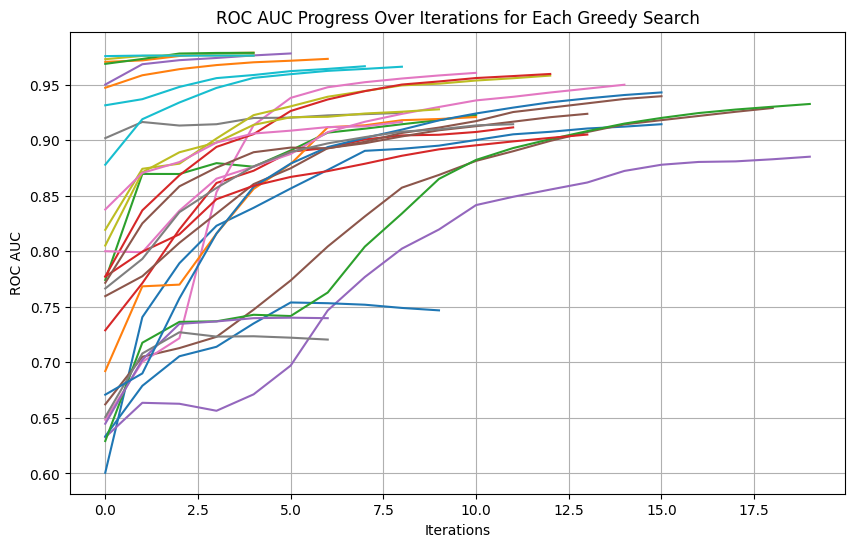

In [24]:
best_aug = uq.perform_greedy_policy_search('savedpolicies', correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=True)
n, m, transformations = uq.extract_gps_augmentations_info(best_aug)

In [ ]:
transformations = ['[(9, np.float64(18.993544968225756)), (12, np.float64(-1.372124799393923))]',
 '[(9, np.float64(13.796092578543764)), (13, np.float64(9.650253122391298))]',
 '[(9, np.float64(26.753347976507428)), (4, np.float64(-2.269870568517014))]',
 '[(10, np.float64(1.7976877272614402)), (14, np.float64(-2.253227258808664))]',
 '[(11, np.float64(-7.330877383517148)), (13, np.float64(17.226544341423256))]']

['[(9, np.float64(18.993544968225756)), (12, np.float64(-1.372124799393923))]',
 '[(9, np.float64(13.796092578543764)), (13, np.float64(9.650253122391298))]',
 '[(9, np.float64(26.753347976507428)), (4, np.float64(-2.269870568517014))]',
 '[(10, np.float64(1.7976877272614402)), (14, np.float64(-2.253227258808664))]',
 '[(11, np.float64(-7.330877383517148)), (13, np.float64(17.226544341423256))]']

In [25]:
stds_GPS_calibration, global_preds_GPS_calibration = uq.TTA(transformations, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

Manually set transform. Current transform: 
[(9,np.float64(18.993544968225756)),(12,np.float64(-1.372124799393923))]
Manually set transform. Current transform: 
[(9,np.float64(13.796092578543764)),(13,np.float64(9.650253122391298))]
Manually set transform. Current transform: 
[(9,np.float64(26.753347976507428)),(4,np.float64(-2.269870568517014))]
Manually set transform. Current transform: 
[(10,np.float64(1.7976877272614402)),(14,np.float64(-2.253227258808664))]
Manually set transform. Current transform: 
[(11,np.float64(-7.330877383517148)),(13,np.float64(17.226544341423256))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


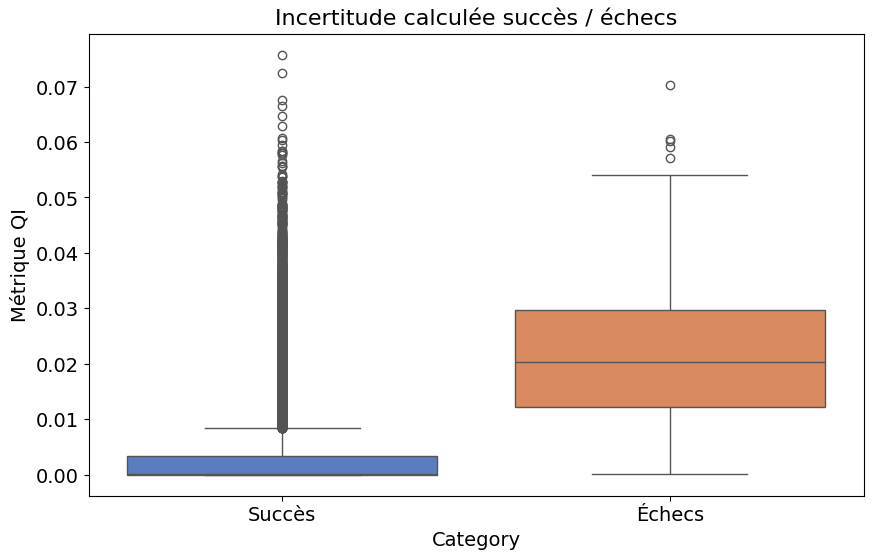

In [26]:
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS_calibration[k] for k in correct_predictions], [stds_GPS_calibration[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_GPS_calibration[k] for k in correct_predictions], [stds_GPS_calibration[j] for j in incorrect_predictions], 'Métrique QI', 'Incertitude calculée succès / échecs', swarmplot=False)

In [27]:
auc_std_gps

np.float64(0.9079901170727144)

In [28]:
distances = uq.distance_to_hard_labels_computation(y_prob)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


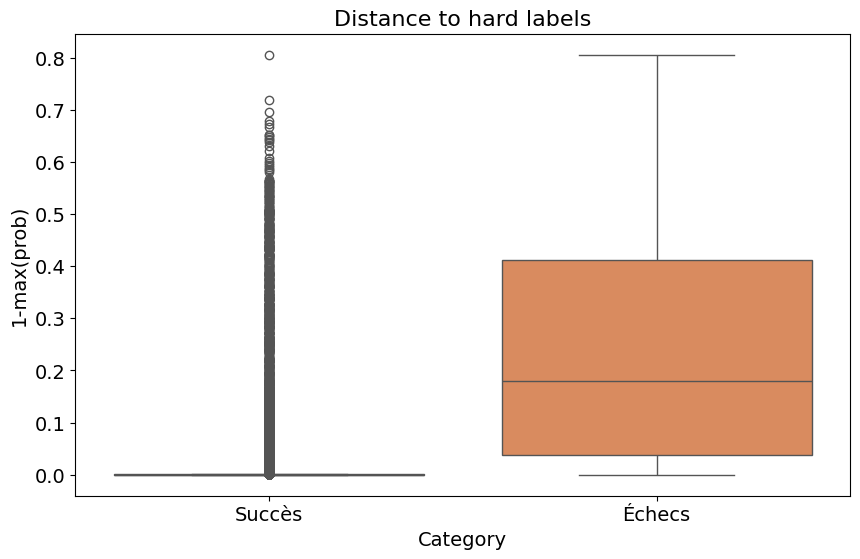

In [29]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Distance to hard labels', swarmplot=False)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


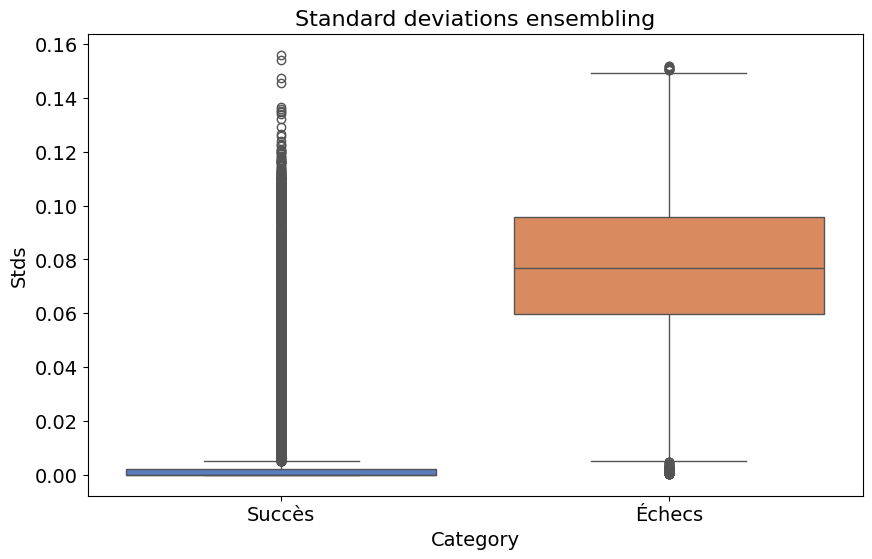

In [30]:
stds = uq.ensembling_stds_computation(indiv_scores)
uq.UQ_method_plot([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions], 'Stds', 'Standard deviations ensembling', swarmplot=False)

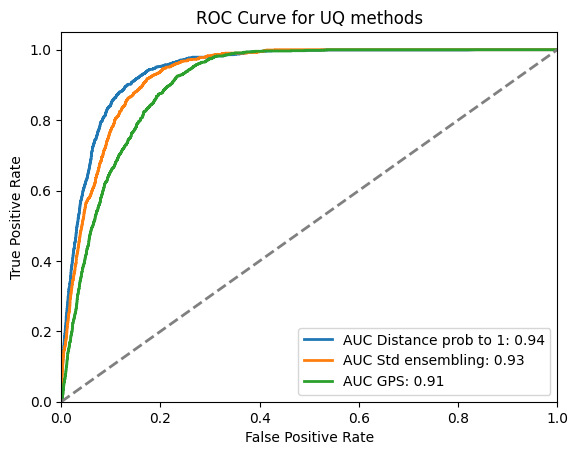

In [31]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
fpr_stds, tpr_stds, auc_stds = uq.roc_curve_UQ_method_computation([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling', 'GPS'], [fpr_distance_to_hard_labels, fpr_stds, fpr_std_gps], [tpr_distance_to_hard_labels, tpr_stds, tpr_std_gps], [auc_distance_to_hard_labels, auc_stds, auc_std_gps])

In [ ]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances, stds_GPS_calibration)))

In [ ]:
mean_values_noGPS = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances)))

In [ ]:
uq.UQ_method_plot([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions], 'Mean(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label + GPS', swarmplot=False)

In [ ]:
fpr_comb, tpr_comb, auc_comb = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
fpr_comb_noGPS, tpr_comb_noGPS, auc_comb_noGPS = uq.roc_curve_UQ_method_computation([mean_values_noGPS[k] for k in correct_predictions], [mean_values_noGPS[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling', 'GPS', 'Combination', 'Combination_noGPS'], [fpr_distance_to_hard_labels, fpr_stds, fpr_std_gps, fpr_comb, fpr_comb_noGPS], [tpr_distance_to_hard_labels, tpr_stds, tpr_std_gps, tpr_comb, tpr_comb_noGPS], [auc_distance_to_hard_labels, auc_stds, auc_std_gps, auc_comb, auc_comb_noGPS])

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

# Define the metrics
metrics = {
    "Dist to HL": distances,
    "Std": stds
}

# Define the labels
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_values))])

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels, max_fp_rate=0.001):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_tp = 0
    total_cases = len(labels)
    max_fp = total_cases * max_fp_rate
    for threshold in thresholds:
        tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if fp <= max_fp and tp > best_tp:
            best_tp = tp
            best_threshold = threshold
    return best_threshold

# Function to summarize results
def summarize_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    total_cases = len(labels)
    tp_proportion = tp / total_cases
    fp_proportion = fp / total_cases
    return tp, tp_proportion, fp, fp_proportion

def display_confusion_matrix_success_flags_prop(cm):
    # Convert cm to a Pandas DataFrame
    df_cm = pd.DataFrame(cm, index=['Failures', 'Success'], columns=['Failures', 'Success'])

    # Convert to proportions (normalize by total sum)
    cm_proportions = (cm.astype(np.float64) / cm.sum()) * 100  # Convert to percentage
    cm_proportions = pd.DataFrame(cm_proportions, index=df_cm.index, columns=df_cm.columns)  # Convert to DataFrame

    # Initialize annotations with the same shape as df_cm
    annotations = df_cm.copy().astype(str)

    # Add percentage values to the confusion matrix
    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            annotations.iloc[i, j] = f"{df_cm.iloc[i, j]} ({cm_proportions.iloc[i, j]:.1f}%)"

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=annotations, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
# Define a function to display the confusion matrix and metrics
def display_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    cm = confusion_matrix(labels, (uq_values <= threshold).astype(int))
    display_confusion_matrix_success_flags_prop(cm)
    print(f"Threshold: {threshold}")
    print(f"Specificity (TNR): {specificity:.2f}")
    print(f"Sensitivity (TPR): {sensitivity:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

# Create a DataFrame to store the results
results = []

# Perform ablation study for each metric separately
for metric_name, uq_values in metrics.items():
    best_threshold = find_optimal_threshold(uq_values, labels)
    tp, tp_proportion, fp, fp_proportion = summarize_results(uq_values, labels, best_threshold)
    results.append([metric_name, f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
    display_results(uq_values, labels, best_threshold)

# Perform ablation study for combinations of metrics
for r in range(2, len(metrics) + 1):
    for combination in itertools.combinations(metrics.keys(), r):
        combined_uq_values = uq.standardize_and_mean_ensembling(np.column_stack([metrics[key] for key in combination]))
        best_threshold = find_optimal_threshold(combined_uq_values, labels)
        tp, tp_proportion, fp, fp_proportion = summarize_results(combined_uq_values, labels, best_threshold)
        results.append([", ".join(combination), f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
        display_results(combined_uq_values, labels, best_threshold)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Metric(s)", "TP (Count, Proportion)", "FP (Count, Proportion)"])

# Display the results
print(results_df)